___
### **Pergunta 32 - Variação mensal na Receita levanto em conta os parcelamentos**
___

In [ ]:
# Google Colab

# Instalação do Spark
!pip install pyspark

# Inicializa a seção
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
# Leitura dos dados

df1 = spark.read.csv('/content/olist_order_payments_dataset.csv' , header=True, inferSchema=True)
df1.createOrReplaceTempView("order_payments")

df2 = spark.read.csv('/content/olist_orders_dataset.csv' , header=True, inferSchema=True)
df2.createOrReplaceTempView("orders")

df3 = spark.read.csv('/content/olist_products_dataset.csv' , header=True, inferSchema=True)
df3.createOrReplaceTempView("products")

df4 = spark.read.csv('/content/olist_order_items_dataset.csv' , header=True, inferSchema=True)
df4.createOrReplaceTempView("order_items")

In [6]:
# Código para gerar sintaxe "Case When" para marcação das parcelas

# mes_max = 12
# ano_min = 2016
# ano_max = 2020

# lista_mes = [str(mes).zfill(2) for mes in range(1, mes_max+1)]

# lista_ano = list(range(2016,ano_max+1))
# lista_ano = [str(ano) for ano in range(ano_min, ano_max+1)]


# for i in lista_ano:
#     for j in lista_mes:
#         print(f"case when ultima_parcela >= {i}{j} and data_aprov < {i}{j} then valor_parcela else 0 end as parcela_{i}{j},")

In [188]:
# Tabela com as parcelas agrupada por categoria

# Foi criada uma situação hipotética de cobrança de juros de acordo com o VALOR do produto

result = spark.sql('''

with tab2 as (
    with tab1 as (
        select
        op.order_id,                                                                                                              -- obs: tem order_id que não está na tabela (somente o da venda de 201609) order_payments.
        op.payment_sequential,                                                                                                    -- Por isso, vamos usar o ID dessa tabela pois, quaisquer outros id que não estejam nela, não tem como saber a quantidade de parcelas, etc.
        op.payment_type,
        op.payment_installments,
        op.payment_value,
        case                                                                                                                      -- aplica política de juros hipotética sobre o valor
          when payment_value <= 100 then 1.015* (payment_value / payment_installments)
          when payment_value > 100 and payment_value <= 500  then 1.025* (payment_value / payment_installments)
          when payment_value > 500 then 1.04* (payment_value / payment_installments)
        end as valor_parcela,
        case                                                                                                                      -- mostra o valor final, com juros
          when payment_value <= 100 then 1.015* payment_value
          when payment_value > 100 and payment_value <= 500  then 1.025* payment_value
          when payment_value > 500 then 1.04* payment_value
          end as valor_final,
        case                                                                                                                      -- mostra o valor da parcela
          when payment_value <= 100 then 0.015* payment_value
          when payment_value > 100 and payment_value <= 500  then 0.025* payment_value
          when payment_value > 500 then 0.04* payment_value
        end as valor_juros,
        coalesce(p.product_category_name, 'sem-info') as categoria                                                               -- a categoria nula pode entrar nototal, pois gerou caixa
        from order_payments op
        left join (select distinct order_id, product_id from order_items) oi on op.order_id = oi.order_id                        -- join com valores únicos de ID da tabela order_items
        left join products p on oi.product_id = p.product_id                                                                     -- join com a tabela de produtos
    )
    select
    payment_installments as qtd_parcelas,
    valor_parcela,
    date_format(o.order_approved_at , 'yyyyMM') AS data_aprov,
    case                                                                                                                         -- Verifica se existe somente uma parcela. Se sim, é pagamento que cai no mesmo mês
      when payment_installments > 1 then date_format(add_months(to_date(data_aprov, 'yyyyMM'), payment_installments), 'yyyyMM')
      else data_aprov
    end AS ultima_parcela,
    datediff(to_date(ultima_parcela, 'yyyyMM'), to_date(date_format(o.order_approved_at , 'yyyyMM'), 'yyyyMM')) as dif_dias,     -- Trata o texto convertendo-o em data e calcula a diferença entre a data de aprvação e a da última parcela
    categoria
    from tab1
    left join orders o on tab1.order_id = o.order_id
    where o.order_status <> 'canceled'                                                                                           -- Alguns pedidos são cancelados
)
select
qtd_parcelas,
valor_parcela,
data_aprov,
ultima_parcela,
categoria,
case when ultima_parcela >= 201601 and data_aprov <= 201601 then valor_parcela else 0 end as parcela_201601,                     -- A data em questão tem que ser maior ou igual a data de aprovação E menor ou igual a data_final
case when ultima_parcela >= 201602 and data_aprov <= 201602 then valor_parcela else 0 end as parcela_201602,
case when ultima_parcela >= 201603 and data_aprov <= 201603 then valor_parcela else 0 end as parcela_201603,
case when ultima_parcela >= 201604 and data_aprov <= 201604 then valor_parcela else 0 end as parcela_201604,
case when ultima_parcela >= 201605 and data_aprov <= 201605 then valor_parcela else 0 end as parcela_201605,
case when ultima_parcela >= 201606 and data_aprov <= 201606 then valor_parcela else 0 end as parcela_201606,
case when ultima_parcela >= 201607 and data_aprov <= 201607 then valor_parcela else 0 end as parcela_201607,
case when ultima_parcela >= 201608 and data_aprov <= 201608 then valor_parcela else 0 end as parcela_201608,
case when ultima_parcela >= 201609 and data_aprov <= 201609 then valor_parcela else 0 end as parcela_201609,
case when ultima_parcela >= 201610 and data_aprov <= 201610 then valor_parcela else 0 end as parcela_201610,
case when ultima_parcela >= 201611 and data_aprov <= 201611 then valor_parcela else 0 end as parcela_201611,
case when ultima_parcela >= 201612 and data_aprov <= 201612 then valor_parcela else 0 end as parcela_201612,
case when ultima_parcela >= 201701 and data_aprov <= 201701 then valor_parcela else 0 end as parcela_201701,
case when ultima_parcela >= 201702 and data_aprov <= 201702 then valor_parcela else 0 end as parcela_201702,
case when ultima_parcela >= 201703 and data_aprov <= 201703 then valor_parcela else 0 end as parcela_201703,
case when ultima_parcela >= 201704 and data_aprov <= 201704 then valor_parcela else 0 end as parcela_201704,
case when ultima_parcela >= 201705 and data_aprov <= 201705 then valor_parcela else 0 end as parcela_201705,
case when ultima_parcela >= 201706 and data_aprov <= 201706 then valor_parcela else 0 end as parcela_201706,
case when ultima_parcela >= 201707 and data_aprov <= 201707 then valor_parcela else 0 end as parcela_201707,
case when ultima_parcela >= 201708 and data_aprov <= 201708 then valor_parcela else 0 end as parcela_201708,
case when ultima_parcela >= 201709 and data_aprov <= 201709 then valor_parcela else 0 end as parcela_201709,
case when ultima_parcela >= 201710 and data_aprov <= 201710 then valor_parcela else 0 end as parcela_201710,
case when ultima_parcela >= 201711 and data_aprov <= 201711 then valor_parcela else 0 end as parcela_201711,
case when ultima_parcela >= 201712 and data_aprov <= 201712 then valor_parcela else 0 end as parcela_201712,
case when ultima_parcela >= 201801 and data_aprov <= 201801 then valor_parcela else 0 end as parcela_201801,
case when ultima_parcela >= 201802 and data_aprov <= 201802 then valor_parcela else 0 end as parcela_201802,
case when ultima_parcela >= 201803 and data_aprov <= 201803 then valor_parcela else 0 end as parcela_201803,
case when ultima_parcela >= 201804 and data_aprov <= 201804 then valor_parcela else 0 end as parcela_201804,
case when ultima_parcela >= 201805 and data_aprov <= 201805 then valor_parcela else 0 end as parcela_201805,
case when ultima_parcela >= 201806 and data_aprov <= 201806 then valor_parcela else 0 end as parcela_201806,
case when ultima_parcela >= 201807 and data_aprov <= 201807 then valor_parcela else 0 end as parcela_201807,
case when ultima_parcela >= 201808 and data_aprov <= 201808 then valor_parcela else 0 end as parcela_201808,
case when ultima_parcela >= 201809 and data_aprov <= 201809 then valor_parcela else 0 end as parcela_201809,
case when ultima_parcela >= 201810 and data_aprov <= 201810 then valor_parcela else 0 end as parcela_201810,
case when ultima_parcela >= 201811 and data_aprov <= 201811 then valor_parcela else 0 end as parcela_201811,
case when ultima_parcela >= 201812 and data_aprov <= 201812 then valor_parcela else 0 end as parcela_201812,
case when ultima_parcela >= 201901 and data_aprov <= 201901 then valor_parcela else 0 end as parcela_201901,
case when ultima_parcela >= 201902 and data_aprov <= 201902 then valor_parcela else 0 end as parcela_201902,
case when ultima_parcela >= 201903 and data_aprov <= 201903 then valor_parcela else 0 end as parcela_201903,
case when ultima_parcela >= 201904 and data_aprov <= 201904 then valor_parcela else 0 end as parcela_201904,
case when ultima_parcela >= 201905 and data_aprov <= 201905 then valor_parcela else 0 end as parcela_201905,
case when ultima_parcela >= 201906 and data_aprov <= 201906 then valor_parcela else 0 end as parcela_201906,
case when ultima_parcela >= 201907 and data_aprov <= 201907 then valor_parcela else 0 end as parcela_201907,
case when ultima_parcela >= 201908 and data_aprov <= 201908 then valor_parcela else 0 end as parcela_201908,
case when ultima_parcela >= 201909 and data_aprov <= 201909 then valor_parcela else 0 end as parcela_201909,
case when ultima_parcela >= 201910 and data_aprov <= 201910 then valor_parcela else 0 end as parcela_201910,
case when ultima_parcela >= 201911 and data_aprov <= 201911 then valor_parcela else 0 end as parcela_201911,
case when ultima_parcela >= 201912 and data_aprov <= 201912 then valor_parcela else 0 end as parcela_201912,
case when ultima_parcela >= 202001 and data_aprov <= 202001 then valor_parcela else 0 end as parcela_202001,
case when ultima_parcela >= 202002 and data_aprov <= 202002 then valor_parcela else 0 end as parcela_202002,
case when ultima_parcela >= 202003 and data_aprov <= 202003 then valor_parcela else 0 end as parcela_202003,
case when ultima_parcela >= 202004 and data_aprov <= 202004 then valor_parcela else 0 end as parcela_202004,
case when ultima_parcela >= 202005 and data_aprov <= 202005 then valor_parcela else 0 end as parcela_202005,
case when ultima_parcela >= 202006 and data_aprov <= 202006 then valor_parcela else 0 end as parcela_202006,
case when ultima_parcela >= 202007 and data_aprov <= 202007 then valor_parcela else 0 end as parcela_202007,
case when ultima_parcela >= 202008 and data_aprov <= 202008 then valor_parcela else 0 end as parcela_202008,
case when ultima_parcela >= 202009 and data_aprov <= 202009 then valor_parcela else 0 end as parcela_202009,
case when ultima_parcela >= 202010 and data_aprov <= 202010 then valor_parcela else 0 end as parcela_202010,
case when ultima_parcela >= 202011 and data_aprov <= 202011 then valor_parcela else 0 end as parcela_202011,
case when ultima_parcela >= 202012 and data_aprov <= 202012 then valor_parcela else 0 end as parcela_202012
from tab2


''')

# Exibe
result.show(truncate=False)

+------------+------------------+----------+--------------+-----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+------------

In [8]:
# Código para gerar sintaxe "Sum" para soma das parcelas

# for i in lista_ano:
#     for j in lista_mes:
#         print(f"sum(parcela_{i}{j}) as mes_{i}{j},")

In [189]:
# Consulta agrupando por data

# Extrai um trecho do dataframe inicial (exclui colunas 0, 1, 2 e 3).
# Não captura as colunas qtd_parcela, svalor_parcela, data_aprov e ultima_parcela )
tab_agrup_categ = result.select(*result.columns[4:])

# Cria a view temporária
tab_agrup_categ.createOrReplaceTempView("tab_agrup_categ")


result_agrup_categ = spark.sql('''

select
categoria,
sum(parcela_201601) as mes_201601,
sum(parcela_201602) as mes_201602,
sum(parcela_201603) as mes_201603,
sum(parcela_201604) as mes_201604,
sum(parcela_201605) as mes_201605,
sum(parcela_201606) as mes_201606,
sum(parcela_201607) as mes_201607,
sum(parcela_201608) as mes_201608,
sum(parcela_201609) as mes_201609,
sum(parcela_201610) as mes_201610,
sum(parcela_201611) as mes_201611,
sum(parcela_201612) as mes_201612,
sum(parcela_201701) as mes_201701,
sum(parcela_201702) as mes_201702,
sum(parcela_201703) as mes_201703,
sum(parcela_201704) as mes_201704,
sum(parcela_201705) as mes_201705,
sum(parcela_201706) as mes_201706,
sum(parcela_201707) as mes_201707,
sum(parcela_201708) as mes_201708,
sum(parcela_201709) as mes_201709,
sum(parcela_201710) as mes_201710,
sum(parcela_201711) as mes_201711,
sum(parcela_201712) as mes_201712,
sum(parcela_201801) as mes_201801,
sum(parcela_201802) as mes_201802,
sum(parcela_201803) as mes_201803,
sum(parcela_201804) as mes_201804,
sum(parcela_201805) as mes_201805,
sum(parcela_201806) as mes_201806,
sum(parcela_201807) as mes_201807,
sum(parcela_201808) as mes_201808,
sum(parcela_201809) as mes_201809,
sum(parcela_201810) as mes_201810,
sum(parcela_201811) as mes_201811,
sum(parcela_201812) as mes_201812,
sum(parcela_201901) as mes_201901,
sum(parcela_201902) as mes_201902,
sum(parcela_201903) as mes_201903,
sum(parcela_201904) as mes_201904,
sum(parcela_201905) as mes_201905,
sum(parcela_201906) as mes_201906,
sum(parcela_201907) as mes_201907,
sum(parcela_201908) as mes_201908,
sum(parcela_201909) as mes_201909,
sum(parcela_201910) as mes_201910,
sum(parcela_201911) as mes_201911,
sum(parcela_201912) as mes_201912,
sum(parcela_202001) as mes_202001,
sum(parcela_202002) as mes_202002,
sum(parcela_202003) as mes_202003,
sum(parcela_202004) as mes_202004,
sum(parcela_202005) as mes_202005,
sum(parcela_202006) as mes_202006,
sum(parcela_202007) as mes_202007,
sum(parcela_202008) as mes_202008,
sum(parcela_202009) as mes_202009,
sum(parcela_202010) as mes_202010,
sum(parcela_202011) as mes_202011,
sum(parcela_202012) as mes_202012
from tab_agrup_categ
group by all


''')

# Exibe
result_agrup_categ.show(truncate=False)

+---------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-------

In [190]:
# Realiza uma espécia de "pivotamento", agrupando as datas em linhas e transformando as categorias em colunas

# Importa funções
from pyspark.sql.functions import explode, col, lit, regexp_replace
from pyspark.sql import functions as F

# Lista de colunas de mês
meses = [c for c in result_agrup_categ.columns if c != 'categoria']

# Usando a função explode para expandir as colunas de mês em linhas
df_exploded = result_agrup_categ.select('categoria', explode(F.array([F.struct(F.lit(c).alias('mês'), col(c).alias('valor')) for c in meses])).alias('exploded'))

# Pivotando os valores da coluna 'categoria' para se tornarem colunas
df_final = df_exploded.groupBy('exploded.mês').pivot('categoria').agg(F.first('exploded.valor'))

# Removendo 'mes_' dos valores da coluna 'mês' e ordenando
df_final = df_final.withColumn('mês', regexp_replace('mês', 'mes_', '').alias('mês')).orderBy('mês')

# Exibindo o DataFrame final
df_final.show()


+------+-------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------------------+----------------------------------+---------------------------------+-----------------------------+--------------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------------+------------------+------------------+----------------------+-----------------------------+-----------------------+------------------------------+------------------+------+---------------+-----------------------------+----------------------+------------------

In [191]:

# colunas_a_somar = df_final.columns[1:]  # Todas as colunas exceto a primeira (mês)

# print('(')
# for i in colunas_a_somar:
#   print(f'{i} +')
# print(') as Total')

In [192]:
# Consulta agrupando por data


# Cria a view temporária
df_final.createOrReplaceTempView("tab_final")


result_final = spark.sql('''

select * ,
(   agro_industria_e_comercio +
    alimentos +
    alimentos_bebidas +
    artes +
    artes_e_artesanato +
    artigos_de_festas +
    artigos_de_natal +
    audio +
    automotivo +
    bebes +
    bebidas +
    beleza_saude +
    brinquedos +
    cama_mesa_banho +
    casa_conforto +
    casa_conforto_2 +
    casa_construcao +
    cds_dvds_musicais +
    cine_foto +
    climatizacao +
    consoles_games +
    construcao_ferramentas_construcao +
    construcao_ferramentas_ferramentas +
    construcao_ferramentas_iluminacao +
    construcao_ferramentas_jardim +
    construcao_ferramentas_seguranca +
    cool_stuff +
    dvds_blu_ray +
    eletrodomesticos +
    eletrodomesticos_2 +
    eletronicos +
    eletroportateis +
    esporte_lazer +
    fashion_bolsas_e_acessorios +
    fashion_calcados +
    fashion_esporte +
    fashion_roupa_feminina +
    fashion_roupa_infanto_juvenil +
    fashion_roupa_masculina +
    fashion_underwear_e_moda_praia +
    ferramentas_jardim +
    flores +
    fraldas_higiene +
    industria_comercio_e_negocios +
    informatica_acessorios +
    instrumentos_musicais +
    la_cuisine +
    livros_importados +
    livros_interesse_geral +
    livros_tecnicos +
    malas_acessorios +
    market_place +
    moveis_colchao_e_estofado +
    moveis_cozinha_area_de_servico_jantar_e_jardim +
    moveis_decoracao +
    moveis_escritorio +
    moveis_quarto +
    moveis_sala +
    musica +
    papelaria +
    pc_gamer +
    pcs +
    perfumaria +
    pet_shop +
    portateis_casa_forno_e_cafe +
    portateis_cozinha_e_preparadores_de_alimentos +
    relogios_presentes +
    seguros_e_servicos +
    sinalizacao_e_seguranca +
    tablets_impressao_imagem +
    telefonia +
    telefonia_fixa +
    utilidades_domesticas ) as Total
from tab_final


''')

# Exibe
result_final.show()

+------+-------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------------------+----------------------------------+---------------------------------+-----------------------------+--------------------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+---------------------------+------------------+------------------+----------------------+-----------------------------+-----------------------+------------------------------+------------------+------+---------------+-----------------------------+----------------------+------------------

In [193]:
# Convertendo a última view em Pandas
tab_final = result_final.toPandas()

# Salva a tabela compilada em formato 'csv'
tab_final.to_csv('/content/tab_compilada.csv', index=False)

In [197]:
# Leitura do dataset
df=pd.read_csv('/content/tab_compilada.csv')

# Exibe
df.sample(5)

,mês,agro_industria_e_comercio,alimentos,alimentos_bebidas,artes,artes_e_artesanato,artigos_de_festas,artigos_de_natal,audio,automotivo,...,portateis_cozinha_e_preparadores_de_alimentos,relogios_presentes,seguros_e_servicos,sem-info,sinalizacao_e_seguranca,tablets_impressao_imagem,telefonia,telefonia_fixa,utilidades_domesticas,Total
34,201811,2389.110239,804.850561,217.335713,201.807406,75.673100,236.520917,339.852968,1809.662562,18362.643302,...,329.810433,47152.885794,0.0,2726.082082,1085.189602,12.323792,11370.669615,406.864754,25562.055210,3.921686e+05
22,201711,10465.280263,1347.785434,2534.920825,344.313394,21.314143,387.002420,1080.655954,3491.306419,37846.693957,...,0.000000,80943.224905,0.0,30874.263450,1289.878033,733.599953,30664.059576,1241.773641,38644.014258,1.077159e+06
40,201905,324.435486,19.405300,22.399325,23.310550,0.000000,0.000000,0.000000,103.199787,2775.382516,...,0.000000,1463.353985,0.0,155.022463,34.986325,0.000000,1047.027300,0.000000,1072.558229,3.263804e+04
16,201705,931.321508,924.582934,655.608943,7509.422075,74.166050,0.000000,31.793183,1503.748438,19356.768610,...,0.000000,25480.072734,0.0,16990.431154,114.550775,1139.052645,11832.344473,1023.818833,22530.542472,4.633910e+05
58,202011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


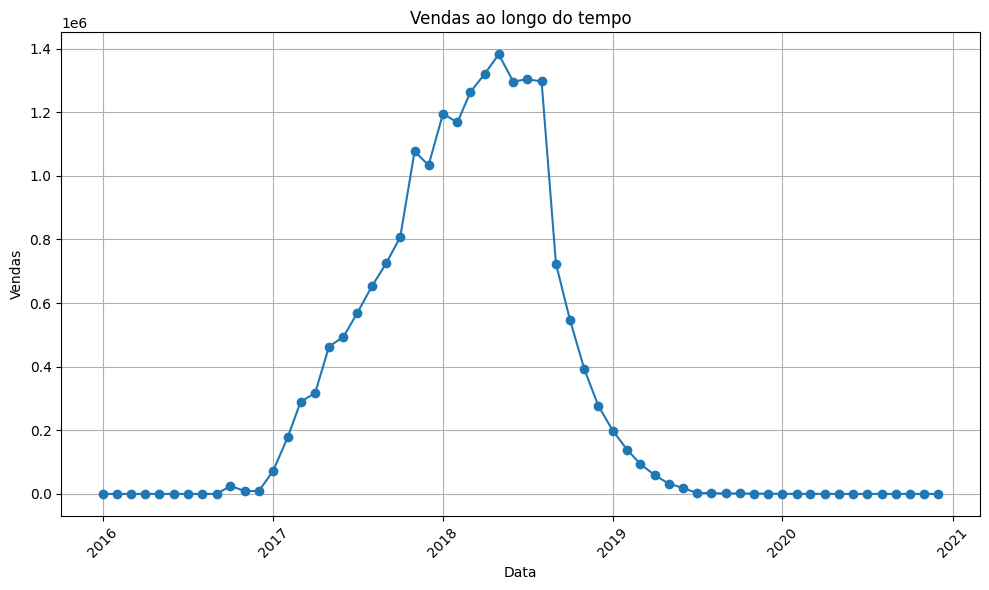

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Dados
meses = df['mês'].values

vendas = df['Total'].values

# Converter números de mês para objetos de data
datas = [datetime.strptime(str(m), '%Y%m') for m in meses]


# Plotando o gráfico com rótulos de datas no eixo X
plt.figure(figsize=(10, 6))
plt.plot(datas, vendas, marker='o', linestyle='-')
plt.title('Vendas ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Vendas')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
